# Qualitative comparison between SLA from SWOT and conventional altimetry, with independent tracer fields (SST, CHL)

## Goal of the notebook

This notebook aims at realising a qualitative comparison between SLA from SWOT and from conventional altimetry data, overlaid on independent tracer fields provided by the SST
anomaly and the surface chlorophyll-a concentration

## Data

To download the data see the README.md. The user will need to define the paths *datadir_swot*, *datadir_convalt*, *datadir_sst*, *datadir_chl* of the folder(s) which holds the data.

## Import modules and open datasets

In [1]:
### IMPORT MODULES ###

import os
from glob import glob
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.interpolate import griddata
import scipy.io
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm
import gc  
import warnings
warnings.filterwarnings("ignore")

In [3]:
### CHLOROPHYLL-a CONCENTRATION ###
datadir_chl='/Users/martina/ex_tesi/datasets/ocean_color/'
ds_oc=xr.open_dataset(datadir_chl+'cmems_obs-oc_med_bgc-plankton_nrt_l3-multi-1km_P1D_1711631176933.nc')

In [ ]:
### SEA SURFACE TEMPERATURE ###
datadir_sst = '/Users/martina/ex_tesi/datasets/sea_surface_temperature/'
ds_sst=xr.open_dataset(datadir_sst+'SST_MED_SST_L3S_NRT_OBSERVATIONS_010_012_b_multi-vars_0.00E-6.00E_36.50N-40.00N_2023-05-01-2023-06-30_(1).nc')

In [ ]:
### SLA CONVENTIONAL ALTIMETRY ###
datadir_conv_alt = '/Users/martina/ex_tesi/Notebooks/'
ds_conv_alt = xr.open_dataset(datadir_conv_alt+'cmems_obs-sl_eur_phy-ssh_my_allsat-l4-duacs-0.0625deg_P1D_multi-vars_0.03E-4.97E_36.03N-39.97N_2023-05-01-2023-06-19.nc')
sla_conv_alt = ds_conv_alt['sla'].sel(longitude=slice(0,6), latitude=slice(36,40))

For SWOT data, it was decided to separate the data in 4 groups in order to facilitate the preprocessing, based on the month (may, june) and on the pass (right, left):

- May, right pass
- May, left pass
- June, right pass
- June, left pass

In [7]:
### SWOT ###

# Directories
datadir_may_right= '/Users/martina/ex_tesi/datasets/swot_data/v_2.0.1/003_may/'
datadir_june_right= '/Users/martina/ex_tesi/datasets/swot_data/v_2.0.1/003_june/'
datadir_may_left= '/Users/martina/ex_tesi/datasets/swot_data/v_2.0.1/016_may/'
datadir_june_left= '/Users/martina/ex_tesi/datasets/swot_data/v_2.0.1/016_june/'

# Dictionary
datasets_may_right = {}
datasets_may_left = {}
datasets_june_right = {}
datasets_june_left = {}

# May right
may_files_right = sorted(glob(os.path.join(datadir_may_right, 'SWOT_L3_LR_SSH_Expert_*_003_202305*_v2.0.1.nc')))
for f in may_files_right:
    date_tag = os.path.basename(f).split('_')[7][:8]
    key = f"ds_003_{date_tag[4:]}"  # -> 'ds_003_0501'
    datasets_may_right[key] = xr.open_dataset(f)

# June right
june_files_right = sorted(glob(os.path.join(datadir_june_right, 'SWOT_L3_LR_SSH_Expert_*_003_202306*_v2.0.1.nc')))
for f in june_files_right:
    date_tag = os.path.basename(f).split('_')[7][:8]
    key = f"ds_003_{date_tag[4:]}"  # -> 'ds_003_0601'
    datasets_june_right[key] = xr.open_dataset(f)

# May left
may_files_left = sorted(glob(os.path.join(datadir_may_left, 'SWOT_L3_LR_SSH_Expert_*_016_202305*_v2.0.1.nc')))
for f in may_files_left:
    date_tag = os.path.basename(f).split('_')[7][:8]
    key = f"ds_016_{date_tag[4:]}"  # -> 'ds_016_0501'
    datasets_may_left[key] = xr.open_dataset(f)

# June left
june_files_left = sorted(glob(os.path.join(datadir_june_left, 'SWOT_L3_LR_SSH_Expert_*_016_202306*_v2.0.1.nc')))
for f in june_files_left:
    date_tag = os.path.basename(f).split('_')[7][:8]
    key = f"ds_016_{date_tag[4:]}"  # -> 'ds_016_0601'
    datasets_june_left[key] = xr.open_dataset(f)


In [8]:
### SWOT NADIR AND SWATHS ###

# Load MAT file
datadir_swot='/Users/martina/ex_tesi/SWOT_coordinates/'
nadir = scipy.io.loadmat(datadir_swot+'swot_calval_hr_Dec2022-v07-nadir.mat')
swath = scipy.io.loadmat(datadir_swot+'swot_calval_hr_Dec2022-v07-swath.mat')

# Print out variable names of file nadir
print("Variable names in the MAT file:")
for key in nadir:
    print(key)

# Access variables in nadir
variable1 = nadir['__header__']
variable2 = nadir['__version__']
variable3 = nadir['__globals__']
variable4 = nadir['lonlat_swot_track_nadir']

# Print out variable names of file swath
print("Variable names in the MAT file:")
for key in swath:
    print(key)

# Access variables in swath
variable5 = swath['__header__']
variable6 = swath['__version__']
variable7 = swath['__globals__']
variable8 = swath['lonlat_swot_track_swath']

# Define latitude and[[[[[['longitude']']']']']'] bounds
lat_min, lat_max = 36, 42
lon_min, lon_max = -2, 8

## NADIR ##

# Extract latitude and[['longitude']'] data from variable4
lat_nadir = variable4[:, 1]
lon_nadir = variable4[:, 0]


# Initialize empty lists to store filtered latitude and[['longitude']'] points
filtered_latitudes = []
filtered_longitudes = []

# Loop through latitude and[['longitude']'] arrays and select points within bounds
for lat, lon in zip(lat_nadir, lon_nadir):
    if lat >= lat_min and lat <= lat_max and lon >= lon_min and lon <= lon_max:
        filtered_latitudes.append(lat)
        filtered_longitudes.append(lon)


# Nadir1
selected_lat_nadir1 = filtered_latitudes[:10]
selected_lon_nadir1 = filtered_longitudes[:10]

# Nadir2
selected_lat_nadir2 = filtered_latitudes[10:20]
selected_lon_nadir2 = filtered_longitudes[10:20]  

## SWATH ##

# Extract latitude and[['longitude']'] data from variable8
lat_swath = variable8[:, 1]
lon_swath = variable8[:, 0]

# Initialize empty lists to store filtered latitude and[['longitude']'] points
filtered_latitudes_swath = []
filtered_longitudes_swath = []

# Loop through latitude and[['longitude']'] arrays and select points within bounds
for lat, lon in zip(lat_swath, lon_swath):
    if lat >= lat_min and lat <= lat_max and lon >= lon_min and lon <= lon_max:
        filtered_latitudes_swath.append(lat)
        filtered_longitudes_swath.append(lon)

selected_lat_swath1 = filtered_latitudes_swath[:10]
selected_lon_swath1 = filtered_longitudes_swath[:10]

selected_lat_swath2 = filtered_latitudes_swath[10:20]
selected_lon_swath2 = filtered_longitudes_swath[10:20]

selected_lat_swath3 = filtered_latitudes_swath[20:30]
selected_lon_swath3 = filtered_longitudes_swath[20:30]

selected_lat_swath4 = filtered_latitudes_swath[31:41]
selected_lon_swath4 = filtered_longitudes_swath[31:41]

selected_lat_swath5 = filtered_latitudes_swath[41:51] 
selected_lon_swath5 = filtered_longitudes_swath[41:51]

selected_lat_swath6 = filtered_latitudes_swath[52:62]
selected_lon_swath6 = filtered_longitudes_swath[52:62]

selected_lat_swath7 = filtered_latitudes_swath[62:72]
selected_lon_swath7 = filtered_longitudes_swath[62:72]

selected_lat_swath8 = filtered_latitudes_swath[72:82]
selected_lon_swath8 = filtered_longitudes_swath[72:82]


Variable names in the MAT file:
__header__
__version__
__globals__
lonlat_swot_track_nadir
Variable names in the MAT file:
__header__
__version__
__globals__
lonlat_swot_track_swath


## Preprocessing of the datasets

### Crop SWOT datasets to the area of interest

In [9]:
# Area of interest
lon_min, lon_max = 1, 5
lat_min, lat_max = 36, 39.5

# Dictionaries for cropped datasets
coastal_may_right = {}
coastal_may_left = {}
coastal_june_right = {}
coastal_june_left = {}

In [10]:
### Function to crop the datasets to the area of interest ###
def crop_datasets(datasets, lon_min, lon_max, lat_min, lat_max):
    cropped_dict = {}
    for key, ds in datasets.items():
        cropped = ds.where(
            (ds['longitude'] > lon_min) & (ds['longitude'] < lon_max) &
            (ds['latitude']  > lat_min) & (ds['latitude']  < lat_max),
            drop=True
        )
        cropped_dict[key] = cropped.load()
        ds.close()
        gc.collect()
    return cropped_dict

In [11]:
# May right
coastal_may_right  = crop_datasets(datasets_may_right, lon_min, lon_max, lat_min, lat_max)

In [12]:
# May left
coastal_may_left   = crop_datasets(datasets_may_left,  lon_min, lon_max, lat_min, lat_max)

In [13]:
# June right
coastal_june_right = crop_datasets(datasets_june_right, lon_min, lon_max, lat_min, lat_max)

In [14]:
# June left
coastal_june_left  = crop_datasets(datasets_june_left,  lon_min, lon_max, lat_min, lat_max)

### Remove mean from SWOT data

In [15]:
### Create ds_* dictionaries with "ssha_filtered" ###

ds_may_right = {}
for key, ds in coastal_may_right.items():
    if key.startswith("ds_003_05"):
        day = key.split("_")[-1]   # es: '0503'
        ds_may_right[f"{day}_r"] = ds["ssha_filtered"]

ds_may_left = {}
for key, ds in coastal_may_left.items():
    if key.startswith("ds_016_05"):
        day = key.split("_")[-1]  
        ds_may_left[f"{day}_l"] = ds["ssha_filtered"]

ds_june_right = {}
for key, ds in coastal_june_right.items():
    if key.startswith("ds_003_06"):
        day = key.split("_")[-1]   
        ds_june_right[f"{day}_r"] = ds["ssha_filtered"]

ds_june_left = {}
for key, ds in coastal_june_left.items():
    if key.startswith("ds_016_06"):
        day = key.split("_")[-1]   
        ds_june_left[f"{day}_l"] = ds["ssha_filtered"]

In [16]:
### Calculate the mean ###
spatial_means_may_right = {k: v.mean(skipna=True) for k, v in ds_may_right.items()}
spatial_means_june_right = {k: v.mean(skipna=True) for k, v in ds_june_right.items()}
spatial_means_may_left = {k: v.mean(skipna=True) for k, v in ds_may_left.items()}
spatial_means_june_left = {k: v.mean(skipna=True) for k, v in ds_june_left.items()}

In [17]:
### Calculate SLA (removing the mean) ###
sla_swot_may_right = {k: ds_may_right[k] - spatial_means_may_right[k] for k in ds_may_right}
sla_swot_june_right = {k: ds_june_right[k] - spatial_means_june_right[k] for k in ds_june_right}
sla_swot_may_left = {k: ds_may_left[k] - spatial_means_may_left[k] for k in ds_may_left}
sla_swot_june_left = {k: ds_june_left[k] - spatial_means_june_left[k] for k in ds_june_left}

### Remove mean from conventional altimetry data

In [18]:
### Calculate the average over an area corresponding to the zone where the eddy propagates ###

sla_conv_alt_mean_values = []
for i in range(len(sla_conv_alt['time'])):
    sla_conv_alt_mean = sla_conv_alt[i,:,:].where((sla_conv_alt['latitude'] > 36.5) & (sla_conv_alt['latitude'] < 40) & (sla_conv_alt['longitude'] > 1) & (sla_conv_alt['longitude'] < 5)).mean()
    # Save mean values in a list
    sla_conv_alt_mean_values.append(sla_conv_alt_mean.values)

# Convert the list into a numpy array
sla_conv_alt_mean_values = np.array(sla_conv_alt_mean_values)

# Convert the numpy array in a DataArray
sla_conv_alt_mean_values_da = xr.DataArray(sla_conv_alt_mean_values, dims=["time"], coords={"time": sla_conv_alt['time']})

# Add the lat and lon dimensions 
sla_conv_alt_mean_values_exp = sla_conv_alt_mean_values_da.expand_dims(dim={"latitude": sla_conv_alt['latitude'], "longitude": sla_conv_alt['longitude']})

# Remove the mean
sla_conv_alt_anomaly = sla_conv_alt - sla_conv_alt_mean_values_exp

### Remove mean from SST (SSTa)

In [19]:
# From Kelvin to Celsius
ds_sst['adjusted_sea_surface_temperature'] -= 273.15
# Update the units attribute
ds_sst['adjusted_sea_surface_temperature'].attrs['units'] = 'degrees Celsius'

# Estract the variable adjusted_sea_surface_temperature
sst = ds_sst['adjusted_sea_surface_temperature']

In [22]:
# Initialize an empty array to store the anomalies
sst_anomalies = []

# Loop through each time step
for i in sst['time']:
    # Calculate spatial mean for the current time step
    spatial_mean = sst.sel(time=i).mean(dim=['latitude', 'longitude'])
    
    # Subtract spatial mean from SST values for the current time step
    ssta = sst.sel(time=i) - spatial_mean
    
    # Append the anomaly for the current time step to the anomalies list
    sst_anomalies.append(ssta)

# Concatenate anomalies along the time dimension to create a single xarray dataset
sst_anomaly_dataset = xr.concat(sst_anomalies, dim='time')

sst_anomaly_dataset.attrs = {
    'long_name': 'Sea Surface Temperature Anomaly',
    'units': '°C',
    'description': 'Difference from the spatial mean of sea surface temperature for each day.'
}

## Figure: Qualitative comparison SLA vs SST and OC

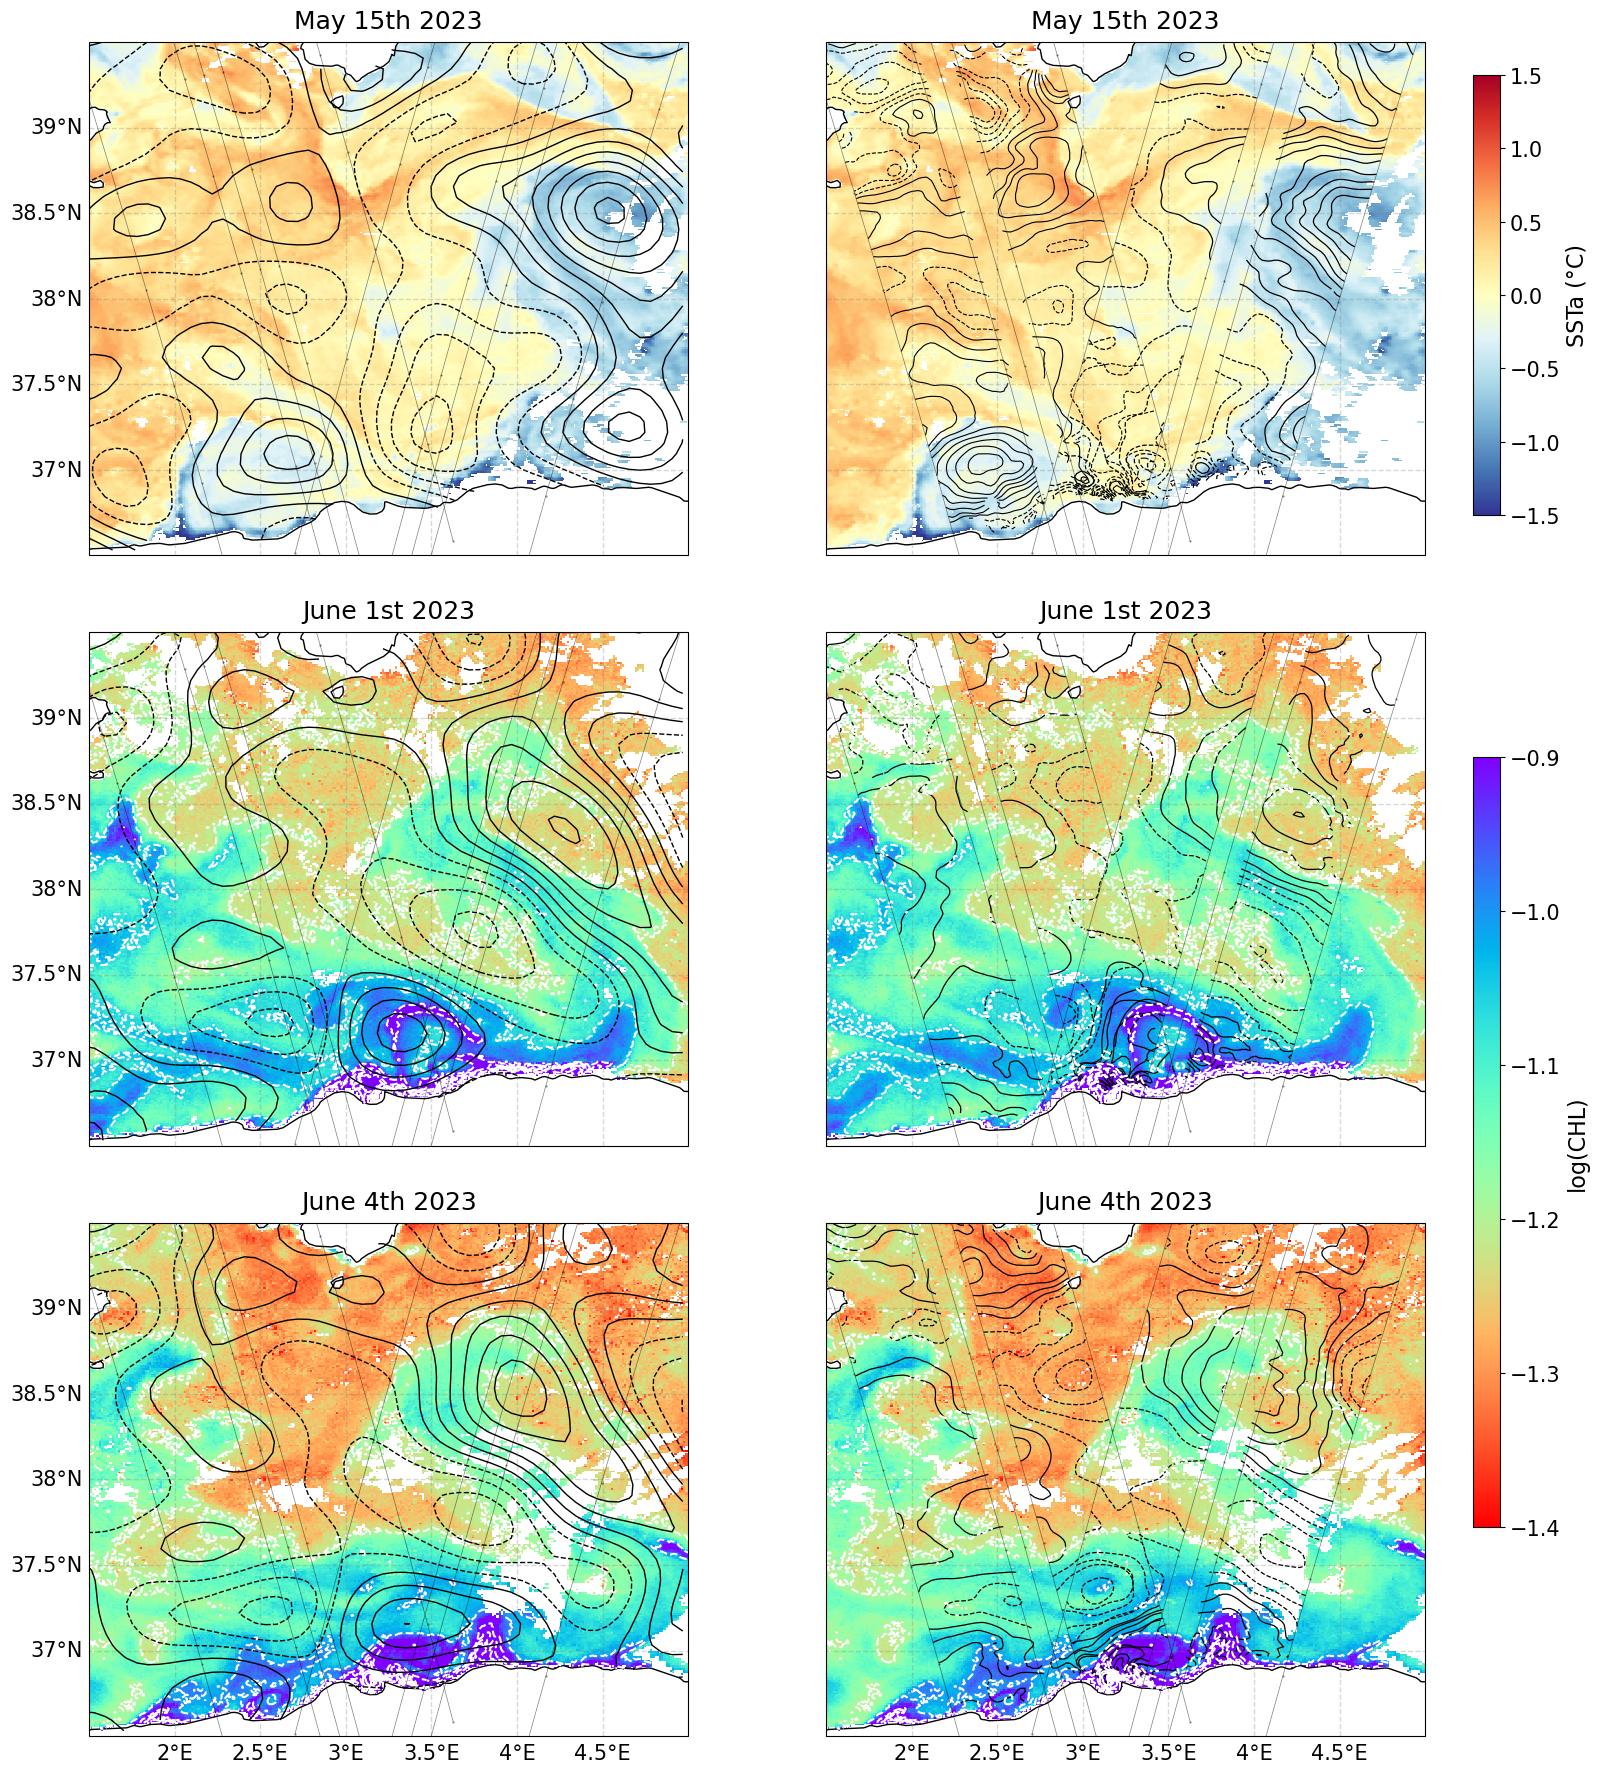

In [23]:
# Create figure with 3 rows and 2 columns
fig, axs = plt.subplots(nrows=3, ncols=2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(18, 22))
plt.subplots_adjust(hspace=0.15, wspace=0.12)

# Global variables 
lon_max, lon_min, lat_max, lat_min = 5, 1.5, 39.5, 36.5 # Map limits

#############################################
# ROW 1 - SLA and SST: Conventional vs SWOT #
#############################################

time_index = 14 # Time index of the day of interest  
vmin, vmax = -1.5, 1.5 # Limits for the SST colormap

### Ax 0,0 ###
ax = axs[0, 0]
sla = sla_conv_alt_anomaly.isel(time=time_index) # Select the time index in the conventional altimetry sla array

# Plot colormap and SLA contours (conventional)
pcm = ax.pcolormesh(sst_anomaly_dataset['longitude'], sst_anomaly_dataset['latitude'], sst_anomaly_dataset[time_index],
                    transform=ccrs.PlateCarree(), cmap='RdYlBu_r', shading='auto', vmin=vmin, vmax=vmax)
ax.contour(sla['longitude'], sla['latitude'], sla, linewidths=1, levels=15, colors='k')

# Coastlines and grid
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.3, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# SWOT tracks
for lon, lat in zip([selected_lon_nadir1, selected_lon_nadir2, selected_lon_swath1, selected_lon_swath2,
                     selected_lon_swath3, selected_lon_swath4, selected_lon_swath5, selected_lon_swath6,
                     selected_lon_swath7, selected_lon_swath8],
                    [selected_lat_nadir1, selected_lat_nadir2, selected_lat_swath1, selected_lat_swath2,
                     selected_lat_swath3, selected_lat_swath4, selected_lat_swath5, selected_lat_swath6,
                     selected_lat_swath7, selected_lat_swath8]):
    ax.plot(lon, lat, color='black', marker='.', markersize=1, lw=0.5, alpha=0.5)

# Map limits
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Title
ax.set_title(f"May 15th 2023", fontsize=18, pad=10)

### Ax 0,1 ###
ax = axs[0, 1]

# Plot colormap and SLA contours (SWOT)
ax.contour(sla_swot_may_right['0514_r']['longitude'], sla_swot_may_right['0514_r']['latitude'], sla_swot_may_right['0514_r'], linewidths=0.9, colors='k', levels=15)
ax.contour(sla_swot_may_left['0514_l']['longitude'], sla_swot_may_left['0514_l']['latitude'], sla_swot_may_left['0514_l'], linewidths=0.8, colors='k', levels=15)
pcm = ax.pcolormesh(sst_anomaly_dataset['longitude'], sst_anomaly_dataset['latitude'], sst_anomaly_dataset[time_index],
                    transform=ccrs.PlateCarree(), cmap='RdYlBu_r', shading='auto', vmin=vmin, vmax=vmax)

#Coastlines and grid
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.3, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}

# Map limits
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# SWOT tracks
for lon, lat in zip([selected_lon_nadir1, selected_lon_nadir2, selected_lon_swath1, selected_lon_swath2,
                     selected_lon_swath3, selected_lon_swath4, selected_lon_swath5, selected_lon_swath6,
                     selected_lon_swath7, selected_lon_swath8],
                    [selected_lat_nadir1, selected_lat_nadir2, selected_lat_swath1, selected_lat_swath2,
                     selected_lat_swath3, selected_lat_swath4, selected_lat_swath5, selected_lat_swath6,
                     selected_lat_swath7, selected_lat_swath8]):
    ax.plot(lon, lat, color='black', marker='.', markersize=1, lw=0.5, alpha=0.5)

# Title
ax.set_title(f"May 15th 2023", fontsize=18, pad=10)

# Colorbar for SST
cbar_ax1 = fig.add_axes([0.91, 0.665, 0.015, 0.2]) 
cbar = fig.colorbar(pcm, cax=cbar_ax1, orientation='vertical')
cbar.set_label('SSTa (°C)', fontsize=16)
cbar.ax.tick_params(labelsize=15)

#ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

#############################################
# ROW 2 - CHL and SLA: Conventional vs SWOT #
#############################################

time_index = 31  # Time index of the day of interest
vmin, vmax = -1.4, -0.9
daily_chl = ds_oc['CHL'].isel(time=time_index) # 
daily_chl_area = daily_chl.sel(latitude=slice(36.5, 40), longitude=slice(0, 6)) # magari mettilo fuori !!!
log_chl = np.log10(daily_chl_area)

### Ax 1,0 ###
ax = axs[1, 0]
sla = sla_conv_alt_anomaly.isel(time=time_index) 

# Plot colormap and SLA contours (conventional)
pcm = ax.pcolormesh(ds_oc['longitude'], ds_oc['latitude'], log_chl, transform=ccrs.PlateCarree(),
                    cmap='rainbow_r', shading='auto', vmin=vmin, vmax=vmax)
ax.contour(ds_oc['longitude'], ds_oc['latitude'], log_chl, linewidths=1.5, colors='white', levels=15)
ax.contour(sla['longitude'], sla['latitude'], sla, linewidths=1, levels=15, colors='k')

# Coastlines and grid
ax.coastlines()
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.3, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}

# Map limits 
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# SWOT tracks
for lon, lat in zip([selected_lon_nadir1, selected_lon_nadir2, selected_lon_swath1, selected_lon_swath2,
                     selected_lon_swath3, selected_lon_swath4, selected_lon_swath5, selected_lon_swath6,
                     selected_lon_swath7, selected_lon_swath8],
                    [selected_lat_nadir1, selected_lat_nadir2, selected_lat_swath1, selected_lat_swath2,
                     selected_lat_swath3, selected_lat_swath4, selected_lat_swath5, selected_lat_swath6,
                     selected_lat_swath7, selected_lat_swath8]):
    ax.plot(lon, lat, color='black', marker='.', markersize=1, lw=0.5, alpha=0.5)

# Title    
ax.set_title(f"June 1st 2023", fontsize=18, pad=10)

### Ax 1,1 ###
ax = axs[1, 1]

# Plot colormap and SLA contours (SWOT)
ax.contour(sla_swot_june_right['0601_r']['longitude'], sla_swot_june_right['0601_r']['latitude'], sla_swot_june_right['0601_r'], linewidths=0.9, colors='k', levels=9)
ax.contour(sla_swot_june_left['0601_l']['longitude'], sla_swot_june_left['0601_l']['latitude'], sla_swot_june_left['0601_l'], linewidths=0.9, colors='k', levels=9)
pcm = ax.pcolormesh(ds_oc['longitude'], ds_oc['latitude'], log_chl, transform=ccrs.PlateCarree(),
                    cmap='rainbow_r', shading='auto', vmin=vmin, vmax=vmax)
ax.contour(ds_oc['longitude'], ds_oc['latitude'], log_chl, linewidths=1.5, colors='white', levels=15)

# Coastlines and grid
ax.coastlines()
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.3, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}

# Map limits
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# SWOT tracks
for lon, lat in zip([selected_lon_nadir1, selected_lon_nadir2, selected_lon_swath1, selected_lon_swath2,
                     selected_lon_swath3, selected_lon_swath4, selected_lon_swath5, selected_lon_swath6,
                     selected_lon_swath7, selected_lon_swath8],
                    [selected_lat_nadir1, selected_lat_nadir2, selected_lat_swath1, selected_lat_swath2,
                     selected_lat_swath3, selected_lat_swath4, selected_lat_swath5, selected_lat_swath6,
                     selected_lat_swath7, selected_lat_swath8]):
    ax.plot(lon, lat, color='black', marker='.', markersize=1, lw=0.5, alpha=0.5)

# Title
ax.set_title(f"June 1st 2023", fontsize=18, pad=10)

#############################################
# ROW 3 - CHL and SLA: Conventional vs SWOT #
#############################################

time_index = 34  # Time index of the day of interest
vmin, vmax = -1.4, -0.9

daily_chl = ds_oc['CHL'].isel(time=time_index)
daily_chl_area = daily_chl.sel(latitude=slice(36.5, 40), longitude=slice(0, 6)) ###MAGRI FUORI !!!
log_chl = np.log10(daily_chl_area)

### Ax 1,0 ###
ax = axs[2, 0]
sla = sla_conv_alt_anomaly.isel(time=time_index) # Select the time index in the conventional altimetry sla array 

# Plot colormap and SLA contours (conventional)
pcm = ax.pcolormesh(ds_oc['longitude'], ds_oc['latitude'], log_chl, transform=ccrs.PlateCarree(),
                    cmap='rainbow_r', shading='auto', vmin=vmin, vmax=vmax)
ax.contour(ds_oc['longitude'], ds_oc['latitude'], log_chl, linewidths=1.5, colors='white', levels=15)
ax.contour(sla['longitude'], sla['latitude'], sla, linewidths=1, levels=15, colors='k')

# Coastlines and grid
ax.coastlines()
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.3, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}

# Map limits
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# SWOT tracks
for lon, lat in zip([selected_lon_nadir1, selected_lon_nadir2, selected_lon_swath1, selected_lon_swath2,
                     selected_lon_swath3, selected_lon_swath4, selected_lon_swath5, selected_lon_swath6,
                     selected_lon_swath7, selected_lon_swath8],
                    [selected_lat_nadir1, selected_lat_nadir2, selected_lat_swath1, selected_lat_swath2,
                     selected_lat_swath3, selected_lat_swath4, selected_lat_swath5, selected_lat_swath6,
                     selected_lat_swath7, selected_lat_swath8]):
    ax.plot(lon, lat, color='black', marker='.', markersize=1, lw=0.5, alpha=0.5)

# Title
ax.set_title(f"June 4th 2023", fontsize=18, pad=10)

### Ax 1,1 ###
ax = axs[2, 1]

# Plot colormap and SLA contours (SWOT)
ax.contour(sla_swot_june_right['0604_r']['longitude'], sla_swot_june_right['0604_r']['latitude'], sla_swot_june_right['0604_r'], linewidths=0.9, colors='k', levels=9)
ax.contour(sla_swot_june_left['0604_l']['longitude'], sla_swot_june_left['0604_l']['latitude'], sla_swot_june_left['0604_l'], linewidths=0.9, colors='k', levels=9)
pcm = ax.pcolormesh(ds_oc['longitude'], ds_oc['latitude'], log_chl, transform=ccrs.PlateCarree(),
                    cmap='rainbow_r', shading='auto', vmin=vmin, vmax=vmax)
ax.contour(ds_oc['longitude'], ds_oc['latitude'], log_chl, linewidths=1.5, colors='white', levels=15)

# Coastlines and grid
ax.coastlines()
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.3, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}

# Map limits
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# SWOT tracks
for lon, lat in zip([selected_lon_nadir1, selected_lon_nadir2, selected_lon_swath1, selected_lon_swath2,
                     selected_lon_swath3, selected_lon_swath4, selected_lon_swath5, selected_lon_swath6,
                     selected_lon_swath7, selected_lon_swath8],
                    [selected_lat_nadir1, selected_lat_nadir2, selected_lat_swath1, selected_lat_swath2,
                     selected_lat_swath3, selected_lat_swath4, selected_lat_swath5, selected_lat_swath6,
                     selected_lat_swath7, selected_lat_swath8]):
    ax.plot(lon, lat, color='black', marker='.', markersize=1, lw=0.5, alpha=0.5)

# Title
ax.set_title(f"June 4th 2023", fontsize=18, pad=10)

# Colorbar for CHL-a
cbar_ax2 = fig.add_axes([0.91, 0.205, 0.015, 0.35])
cbar = fig.colorbar(pcm, cax=cbar_ax2, orientation='vertical')
cbar.set_label('log(CHL)', fontsize=16)
cbar.ax.tick_params(labelsize=15)

plt.show()
